In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### EDA

/var/folders/b3/zdl2xxh53jgc4hjrq6hk1p9c0000gn/T/ipykernel_19641/206269896.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  brent_data = pd.read_csv('../../data/BrentOilPrices.csv', parse_dates=['Date'], index_col='Date')


Brent Data Head:
            Price
Date             
1987-05-20  18.63
1987-05-21  18.45
1987-05-22  18.55
1987-05-25  18.60
1987-05-26  18.63
Brent Data Shape: (9011, 1)

GDP Data Head:
                 GDP
DATE                
1987-04-01  4806.160
1987-07-01  4884.555
1987-10-01  5007.994
1988-01-01  5073.372
1988-04-01  5190.036
GDP Data Shape: (142, 1)

Unemployment Data Head:
            UNRATE
DATE              
1987-05-01     6.3
1987-06-01     6.2
1987-07-01     6.1
1987-08-01     6.0
1987-09-01     5.9
Unemployment Data Shape: (425, 1)

All Data Head:
            Price      GDP  UNRATE
1987-04-01    NaN  4806.16     NaN
1987-05-01    NaN      NaN     6.3
1987-05-20  18.63      NaN     NaN
1987-05-21  18.45      NaN     NaN
1987-05-22  18.55      NaN     NaN
All Data Shape: (9164, 3)

Columns after renaming: Index(['Brent Price', 'GDP', 'Unemployment Rate'], dtype='object')

Index of All Data:
DatetimeIndex(['1987-04-01', '1987-05-01', '1987-05-20', '1987-05-21',
              

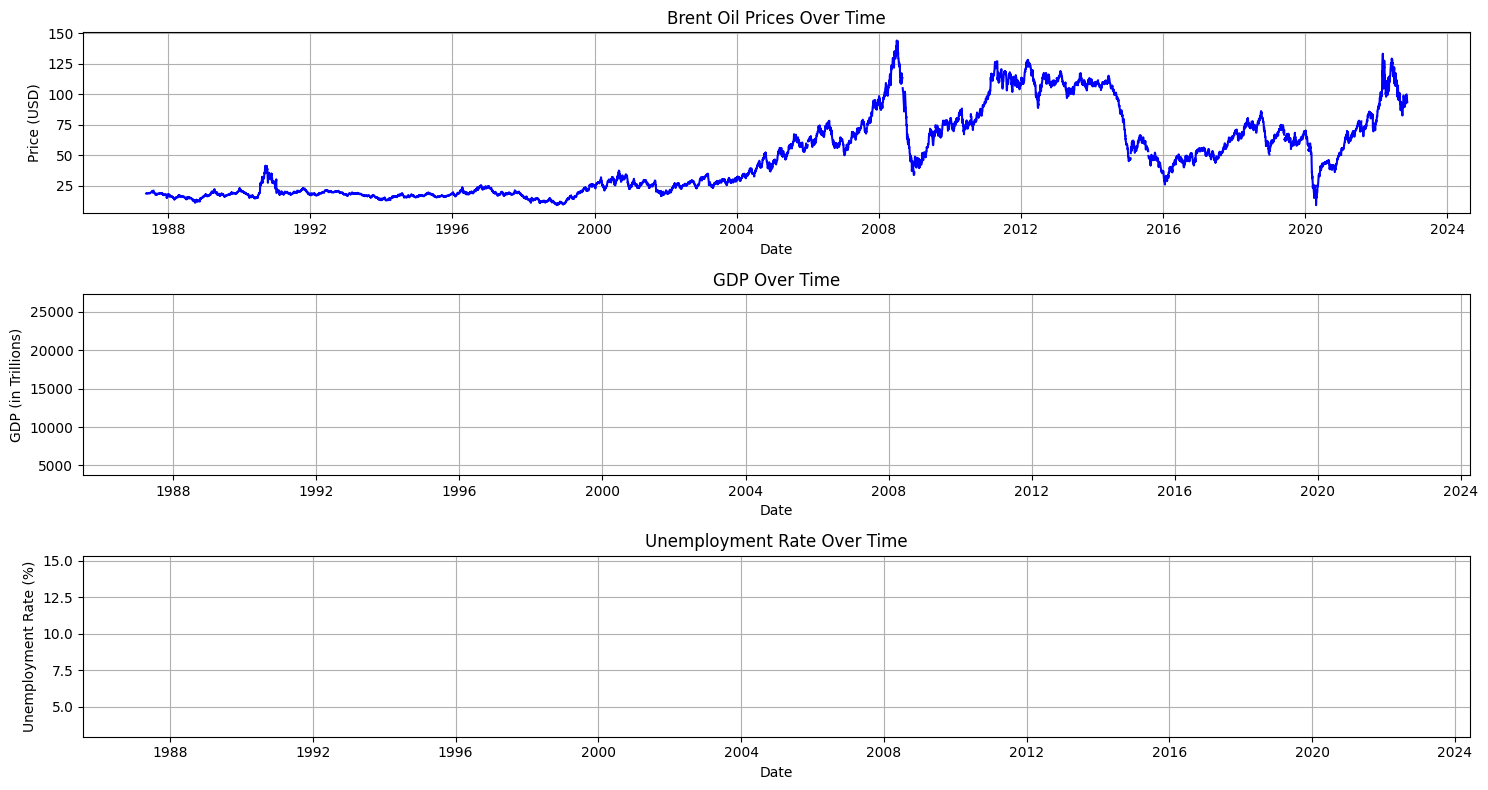

In [5]:

brent_data = pd.read_csv('../../data/BrentOilPrices.csv', parse_dates=['Date'], index_col='Date')
print("Brent Data Head:")
print(brent_data.head())
print("Brent Data Shape:", brent_data.shape)

gdp_data = pd.read_csv('../../data/GDP.csv', parse_dates=['DATE'], index_col='DATE')
print("\nGDP Data Head:")
print(gdp_data.head())
print("GDP Data Shape:", gdp_data.shape)

unemployment_data = pd.read_csv('../../data/UNRATE.csv', parse_dates=['DATE'], index_col='DATE')
print("\nUnemployment Data Head:")
print(unemployment_data.head())
print("Unemployment Data Shape:", unemployment_data.shape)


all_data = brent_data.merge(gdp_data, how='outer', left_index=True, right_index=True)
all_data = all_data.merge(unemployment_data, how='outer', left_index=True, right_index=True)


print("\nAll Data Head:")
print(all_data.head())
print("All Data Shape:", all_data.shape)


all_data.columns = ['Brent Price', 'GDP', 'Unemployment Rate']
print("\nColumns after renaming:", all_data.columns)


print("\nIndex of All Data:")
print(all_data.index)


plt.figure(figsize=(15, 8))


plt.subplot(3, 1, 1)
plt.plot(all_data.index, all_data['Brent Price'], label='Brent Price', color='blue')
plt.title('Brent Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid()


plt.subplot(3, 1, 2)
plt.plot(all_data.index, all_data['GDP'], label='GDP', color='orange')
plt.title('GDP Over Time')
plt.xlabel('Date')
plt.ylabel('GDP (in Trillions)')
plt.grid()


plt.subplot(3, 1, 3)
plt.plot(all_data.index, all_data['Unemployment Rate'], label='Unemployment Rate', color='green')
plt.title('Unemployment Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.grid()

plt.tight_layout()
plt.show()


In [6]:
# Descriptive statistics
stats = all_data.describe()
print("\nDescriptive Statistics:")
print(stats)



Descriptive Statistics:
       Brent Price           GDP  Unemployment Rate
count  9011.000000    142.000000         425.000000
mean     48.420782  12985.794303           5.821647
std      32.860110   5596.050231           1.668804
min       9.100000   4806.160000           3.500000
25%      19.050000   7909.561000           4.700000
50%      38.570000  12647.250000           5.500000
75%      70.090000  17132.473750           6.600000
max     143.950000  26272.011000          14.800000



Correlation Matrix:
                   Brent Price       GDP  Unemployment Rate
Brent Price           1.000000  0.674091           0.185253
GDP                   0.674091  1.000000          -0.032498
Unemployment Rate     0.185253 -0.032498           1.000000


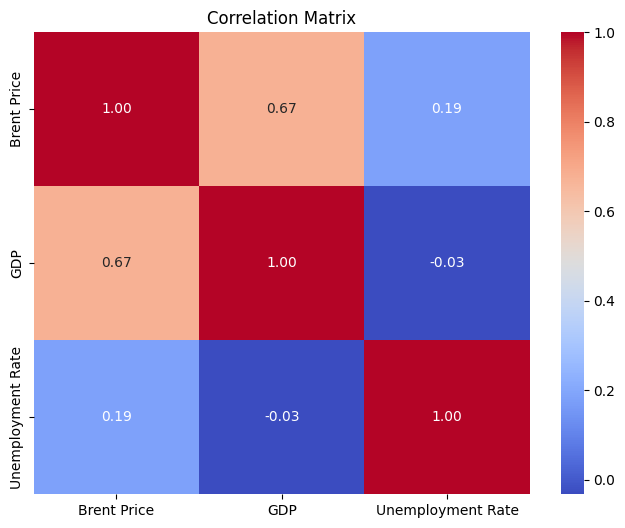

In [7]:
# Correlation matrix
correlation = all_data.corr()
print("\nCorrelation Matrix:")
print(correlation)


plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


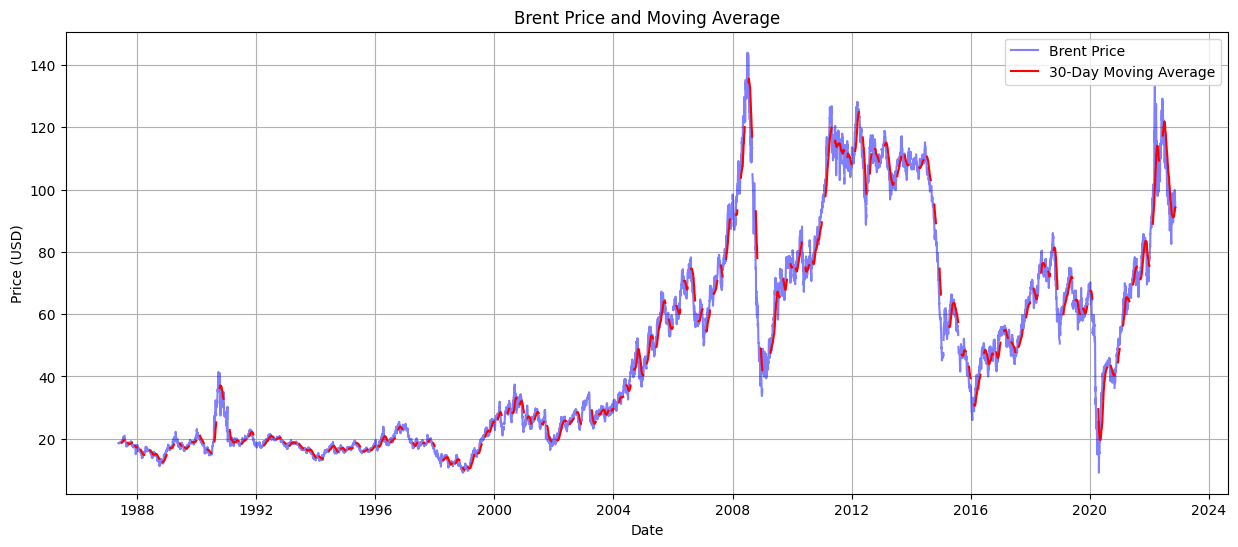

In [8]:

all_data['Brent Price MA'] = all_data['Brent Price'].rolling(window=30).mean()
all_data['GDP MA'] = all_data['GDP'].rolling(window=4).mean()  # Quarterly moving average


plt.figure(figsize=(15, 6))
plt.plot(all_data.index, all_data['Brent Price'], label='Brent Price', color='blue', alpha=0.5)
plt.plot(all_data.index, all_data['Brent Price MA'], label='30-Day Moving Average', color='red')
plt.title('Brent Price and Moving Average')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()


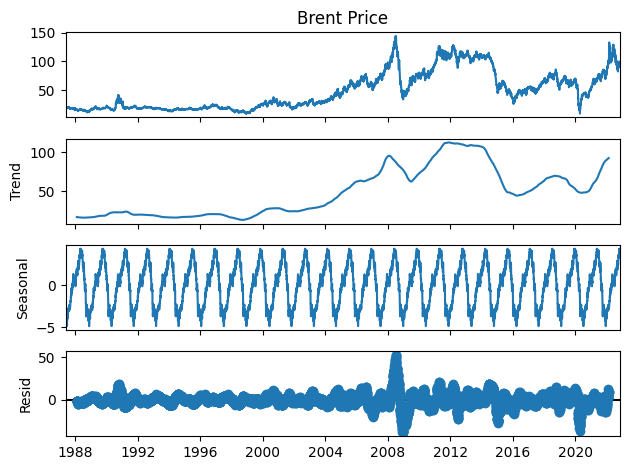

In [9]:


# Decomposing the Brent Price time series
decomposition = seasonal_decompose(all_data['Brent Price'].dropna(), model='additive', period=365)  # Using daily data, period=365
decomposition.plot()
plt.show()


In [10]:


# Selecting relevant columns for VAR model and dropping missing values
var_data = all_data[['Brent Price', 'GDP', 'Unemployment Rate']]
var_data = var_data.dropna()

# Initialize and fit the VAR model
model = VAR(var_data)
model_fitted = model.fit(maxlags=15, ic='aic')
print(model_fitted.summary())

# Forecasting
# Use the correct lag order attribute 'k_ar' for VAR
forecast = model_fitted.forecast(var_data.values[-model_fitted.k_ar:], steps=10)

# Create a DataFrame for the forecast with appropriate date range
forecast_df = pd.DataFrame(
    forecast, 
    index=pd.date_range(start=var_data.index[-1] + pd.DateOffset(months=1), periods=10, freq='M'), 
    columns=var_data.columns
)

print(forecast_df)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 05, Nov, 2024
Time:                     22:25:20
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    21.0965
Nobs:                     59.0000    HQIC:                   18.1341
Log likelihood:          -592.149    FPE:                5.51883e+07
AIC:                      16.2372    Det(Omega_mle):     9.79118e+06
--------------------------------------------------------------------
Results for equation Brent Price
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                       111.079009        51.260245            2.167           0.030
L1.Brent Price                0.682266         0.248346            2.747           0.006
L1.GDP                

/Users/junior/Documents/Tenx/Birhan_Energies/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/folders/b3/zdl2xxh53jgc4hjrq6hk1p9c0000gn/T/ipykernel_19641/1493340717.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index=pd.date_range(start=var_data.index[-1] + pd.DateOffset(months=1), periods=10, freq='M'),


In [11]:


# Example SARIMAX model (this is a simplistic approach)
sarimax_model = SARIMAX(all_data['Brent Price'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_results = sarimax_model.fit()
print(sarimax_results.summary())


/Users/junior/Documents/Tenx/Birhan_Energies/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/junior/Documents/Tenx/Birhan_Energies/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.79260D+00    |proj g|=  2.36592D-01

At iterate    5    f=  1.63154D+00    |proj g|=  8.95940D-02

At iterate   10    f=  1.59281D+00    |proj g|=  1.20587D-02

At iterate   15    f=  1.58968D+00    |proj g|=  2.84100D-03

At iterate   20    f=  1.58961D+00    |proj g|=  6.61264D-04

At iterate   25    f=  1.58957D+00    |proj g|=  8.92588D-04

At iterate   30    f=  1.58947D+00    |proj g|=  4.16812D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

In [12]:

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(all_data[['Brent Price']])

# Prepare data for LSTM
X, y = [], []
for i in range(len(scaled_data) - 10):
    X.append(scaled_data[i:i + 10])
    y.append(scaled_data[i + 10])
X, y = np.array(X), np.array(y)

# Create the LSTM model
model = keras.Sequential([
    layers.LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    layers.LSTM(50),
    layers.Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=50, batch_size=32)


Epoch 1/50


/Users/junior/Documents/Tenx/Birhan_Energies/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: nan
Epoch 2/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: nan
Epoch 3/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: nan
Epoch 4/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: nan
Epoch 5/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: nan
Epoch 6/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: nan
Epoch 7/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: nan
Epoch 8/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: nan
Epoch 9/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: nan
Epoch 10/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: nan
Epoch 11/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: nan
Epoch 12/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: nan
Epoch 13/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: nan
Epoch 14/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: nan
Epoch 15/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: nan
Epoch 16/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4

In [13]:



predicted = model_fitted.forecast(var_data.values[-model_fitted.k_ar:], steps=10)

actual = np.random.rand(10, predicted.shape[1])  # Placeholder for actual data

rmse = np.sqrt(mean_squared_error(actual, predicted))
mae = mean_absolute_error(actual, predicted)
r2 = r2_score(actual, predicted)

print('RMSE:', rmse)
print('MAE:', mae)
print('R^2:', r2)


RMSE: 17313.2380413616
MAE: 9964.639310237391
R^2: -5522322568.865613
